# Task 2 Clustering


In [1]:
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.cluster import KMeans

We upload the dataset obtained after the data preparation phase.

In [2]:
df_incidents = pd.read_csv('../dataset_preparation/incidents_prepared.csv', sep=',', index_col=0)

df_incidents.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 0 to 164506
Data columns (total 32 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       161550 non-null  object 
 1   state                      161550 non-null  object 
 2   city_or_county             161550 non-null  object 
 3   address                    149848 non-null  object 
 4   latitude                   161550 non-null  float64
 5   longitude                  161550 non-null  float64
 6   congressional_district     161550 non-null  float64
 7   avg_age_participants       161550 non-null  float64
 8   n_killed                   161550 non-null  int64  
 9   incident_characteristics1  161550 non-null  object 
 10  year                       161550 non-null  float64
 11  age_group                  161550 non-null  object 
 12  povertyPercentage          161550 non-null  float64
 13  population                 161550 

## Selecting useful features for clustering
Now, we can select the most useful features for clustering. The selection is based on the correlation matrix, seen in the data preparation.
From the original dataset, we selected only the feature `avg_age_participants`.
We then use the features and indicators defined by us: `severity`, `severity_minor`, `killed_by_district`, `injured_by_district`, `povertyPercentage`, `arrested_ratio`, `unharmed_ratio`, `right_or_left`.

In [4]:
df_incidents.columns

Index(['date', 'state', 'city_or_county', 'address', 'latitude', 'longitude',
       'congressional_district', 'avg_age_participants', 'n_killed',
       'incident_characteristics1', 'year', 'age_group', 'povertyPercentage',
       'population', 'party', 'candidatevotes', 'severity', 'severity_cat',
       'severity_minor', 'year_month', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left', 'dfm_district_killed', 'dfm_district_injured',
       'dfm_district_participants', 'dfm_district_child', 'dfm_district_teen',
       'dfm_district_females', 'voters_over_population'],
      dtype='object')

In [5]:
cols_for_clustering =['avg_age_participants', 'povertyPercentage',
        'severity', 'severity_minor', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']

In [6]:
# drop the columns that we don't need
df_incidents_clustering = df_incidents[cols_for_clustering]
df_incidents_clustering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161550 entries, 0 to 164506
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   avg_age_participants  161550 non-null  float64
 1   povertyPercentage     161550 non-null  float64
 2   severity              161550 non-null  float64
 3   severity_minor        161550 non-null  float64
 4   killed_by_district    161550 non-null  float64
 5   injured_by_district   161550 non-null  float64
 6   arrested_ratio        161550 non-null  float64
 7   unharmed_ratio        161550 non-null  float64
 8   right_or_left         161550 non-null  float64
dtypes: float64(9)
memory usage: 12.3 MB


In [7]:
#entropy of each feature
from scipy.stats import entropy
for col in df_incidents_clustering.columns:
    print(col, entropy(df_incidents_clustering[col].value_counts(normalize=True)))

avg_age_participants 3.7726645408807515
povertyPercentage 4.18758888580303
severity 1.795126453848965
severity_minor 0.6260837228952216
killed_by_district 1.4039374353167249
injured_by_district 2.454894647628055
arrested_ratio 1.1864229069442342
unharmed_ratio 1.0220789597622542
right_or_left 6.495060360654568


In [8]:
# we drop the rows with nan
df_incidents_clustering = df_incidents_clustering.dropna()

## Scaling and PCA

We proceed with the scaling in order to have mean 0 and variance 1 for all the attributes.

In [13]:
scaler = StandardScaler()
df_incidents_scaled = scaler.fit_transform(df_incidents_clustering)
df_incidents_scaled = pd.DataFrame(df_incidents_scaled, columns=df_incidents_clustering.columns)
df_incidents_scaled.describe()

avg_age_participants  povertyPercentage      severity  severity_minor  \
count          1.615500e+05       1.615500e+05  1.615500e+05    1.615500e+05   
mean          -1.843761e-16      -2.075990e-16  1.600975e-16    2.199142e-17   
std            1.000003e+00       1.000003e+00  1.000003e+00    1.000003e+00   
min           -2.419643e+00      -2.617057e+00 -1.086602e+00   -3.248521e-01   
25%           -7.315237e-01      -6.516270e-01 -1.086602e+00   -3.248521e-01   
50%           -2.492038e-01      -1.056741e-01  1.059600e-01   -3.248521e-01   
75%            4.742761e-01       5.494693e-01  3.047203e-01   -3.248521e-01   
max            5.297475e+00       3.352027e+00  1.696042e+00    6.710766e+00   

       killed_by_district  injured_by_district  arrested_ratio  \
count        1.615500e+05         1.615500e+05    1.615500e+05   
mean         5.629803e-18        -5.629803e-18   -1.104849e-16   
std          1.000003e+00         1.000003e+00    1.000003e+00   
min         -4.436121e-01        -4.939728e-01   -7.317171e-01   
25%         -4.436121e-01        -4.939728e-01   -7.317171e-01   
50%         -4.436121e-01        -4.939728e-01   -7.317171e-01   
75%         -6.380239e-02         3.729213e-02    5.023855e-01   
max          4.114105e+00         4.287412e+00    1.736488e+00   

       unharmed_ratio  right_or_left  
count    1.615500e+05   1.615500e+05  
mean     1.238557e-16   3.856415e-16  
std      1.000003e+00   1.000003e+00  
min     -5.689729e-01  -2.083602e+00  
25%     -5.689729e-01  -8.098118e-01  
50%     -5.689729e-01  -1.053906e-01  
75%      6.680416e-01   7.901994e-01  
max      2.523563e+00   2.630336e+00

We also use the MinMaxScaler, which scales the data in the range [0,1].

In [14]:
scaler_mm = MinMaxScaler()
df_incidents_scaled_mm = scaler_mm.fit_transform(df_incidents_clustering)
df_incidents_scaled_mm = pd.DataFrame(df_incidents_scaled_mm, columns=df_incidents_clustering.columns)
df_incidents_scaled_mm.describe()

avg_age_participants  povertyPercentage       severity  severity_minor  \
count         161550.000000      161550.000000  161550.000000   161550.000000   
mean               0.313542           0.438435       0.390493        0.046173   
std                0.129582           0.167530       0.359372        0.142134   
min                0.000000           0.000000       0.000000        0.000000   
25%                0.218750           0.329268       0.000000        0.000000   
50%                0.281250           0.420732       0.428571        0.000000   
75%                0.375000           0.530488       0.500000        0.000000   
max                1.000000           1.000000       1.000000        1.000000   

       killed_by_district  injured_by_district  arrested_ratio  \
count       161550.000000        161550.000000   161550.000000   
mean             0.097332             0.103312        0.296457   
std              0.219409             0.209145        0.405154   
min              0.000000             0.000000        0.000000   
25%              0.000000             0.000000        0.000000   
50%              0.000000             0.000000        0.000000   
75%              0.083333             0.111111        0.500000   
max              1.000000             1.000000        1.000000   

       unharmed_ratio  right_or_left  
count   161550.000000  161550.000000  
mean         0.183983       0.442009  
std          0.323360       0.212138  
min          0.000000       0.000000  
25%          0.000000       0.270218  
50%          0.000000       0.419652  
75%          0.400000       0.609639  
max          1.000000       1.000000

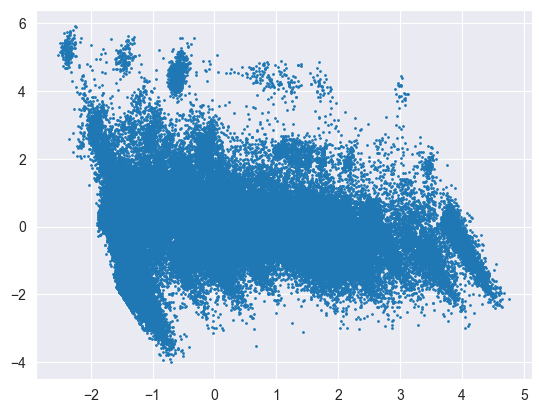

In [15]:
# pca in order to reduce the dimensionality of the dataset
pca = PCA(n_components=2)
df_incidents_pca = pca.fit_transform(df_incidents_scaled)
# plot of the results
plt.scatter(df_incidents_pca[:,0], df_incidents_pca[:,1], s=1)

## K-means

### Selecting the number of clusters with the elbow method

In order to select the k number of clusters, we can use the elbow method: we run k-means for different values of k, and by plotting the SSE, we can see the elbow point, which is the optimal number of clusters.

In [22]:
# elbow method to find the optimal number of clusters
kmeans=[]

SSE = []
for i in range(1, 11):
    kmeans.append( KMeans(n_clusters=i, random_state=0, n_init=1).fit(df_incidents_scaled) )
    SSE.append(kmeans[i-1].inertia_)

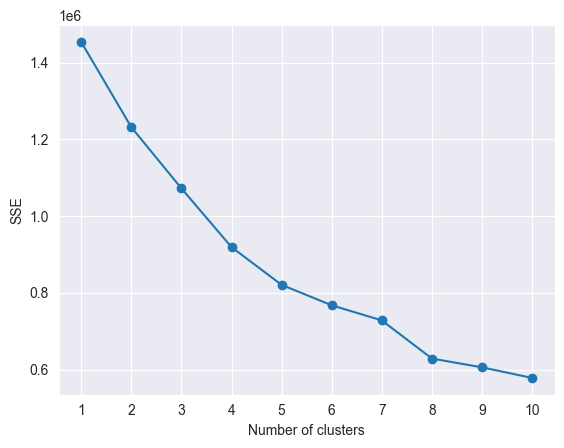

In [29]:
plt.plot( range(1,11),SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
# change numbers on x axis
plt.xticks(np.arange(1, 11, step=1))
plt.show()

In [24]:
#the elbow seems to start at k=4, so we choose this amount of clusters
kmeans = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_incidents_scaled)
df_incidents['cluster_kmeans'] = kmeans.labels_
df_incidents['cluster_kmeans'].value_counts()
df_incidents_clustering['cluster'] = kmeans.labels_

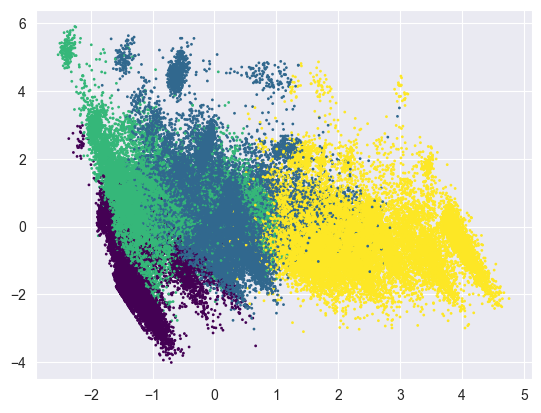

In [25]:
#we report the clusters on the pca plot
plt.scatter(df_incidents_pca[:,0], df_incidents_pca[:,1], c=df_incidents_clustering['cluster'], s=1, cmap='viridis')

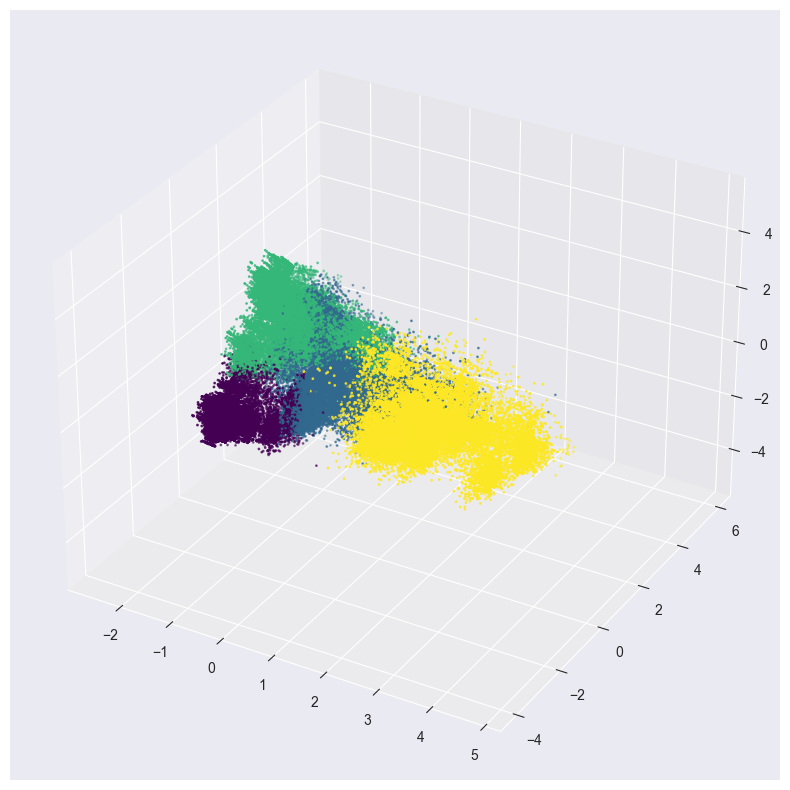

In [26]:
#plot of 3 components-PCA with clusters
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pca= PCA(n_components=3)
df_incidents_pca = pca.fit_transform(df_incidents_scaled)
ax.scatter(df_incidents_pca[:,0], df_incidents_pca[:,1], df_incidents_pca[:,2], c=df_incidents_clustering['cluster'], s=1, cmap='viridis')

Analogously, we can apply the K-means algorithm to the dataset scaled with MinMaxScaler.

In [27]:
# elbow method to find the optimal number of clusters
kmeans_mm=[]

SSE_mm = []
for i in range(1, 11):
    kmeans_mm.append( KMeans(n_clusters=i, random_state=0, n_init=1).fit(df_incidents_scaled_mm) )
    SSE_mm.append(kmeans_mm[i-1].inertia_)

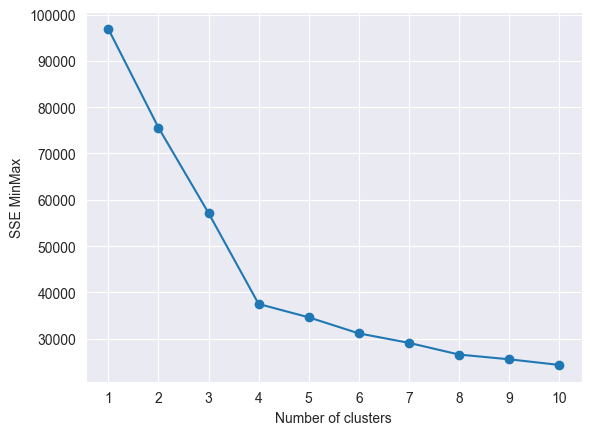

In [30]:
plt.plot( range(1,11),SSE_mm, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE MinMax')
# change numbers on x axis
plt.xticks(np.arange(1, 11, step=1))
plt.show()

In [31]:
#the elbow seems to start at k=4, so we choose this amount of clusters
kmeans_mm = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_incidents_scaled_mm)
df_incidents['cluster_kmeans_mm'] = kmeans_mm.labels_
df_incidents['cluster_kmeans_mm'].value_counts()
df_incidents_clustering['cluster_mm'] = kmeans_mm.labels_

Let's see the clusters on the scatter plots of some selected features.

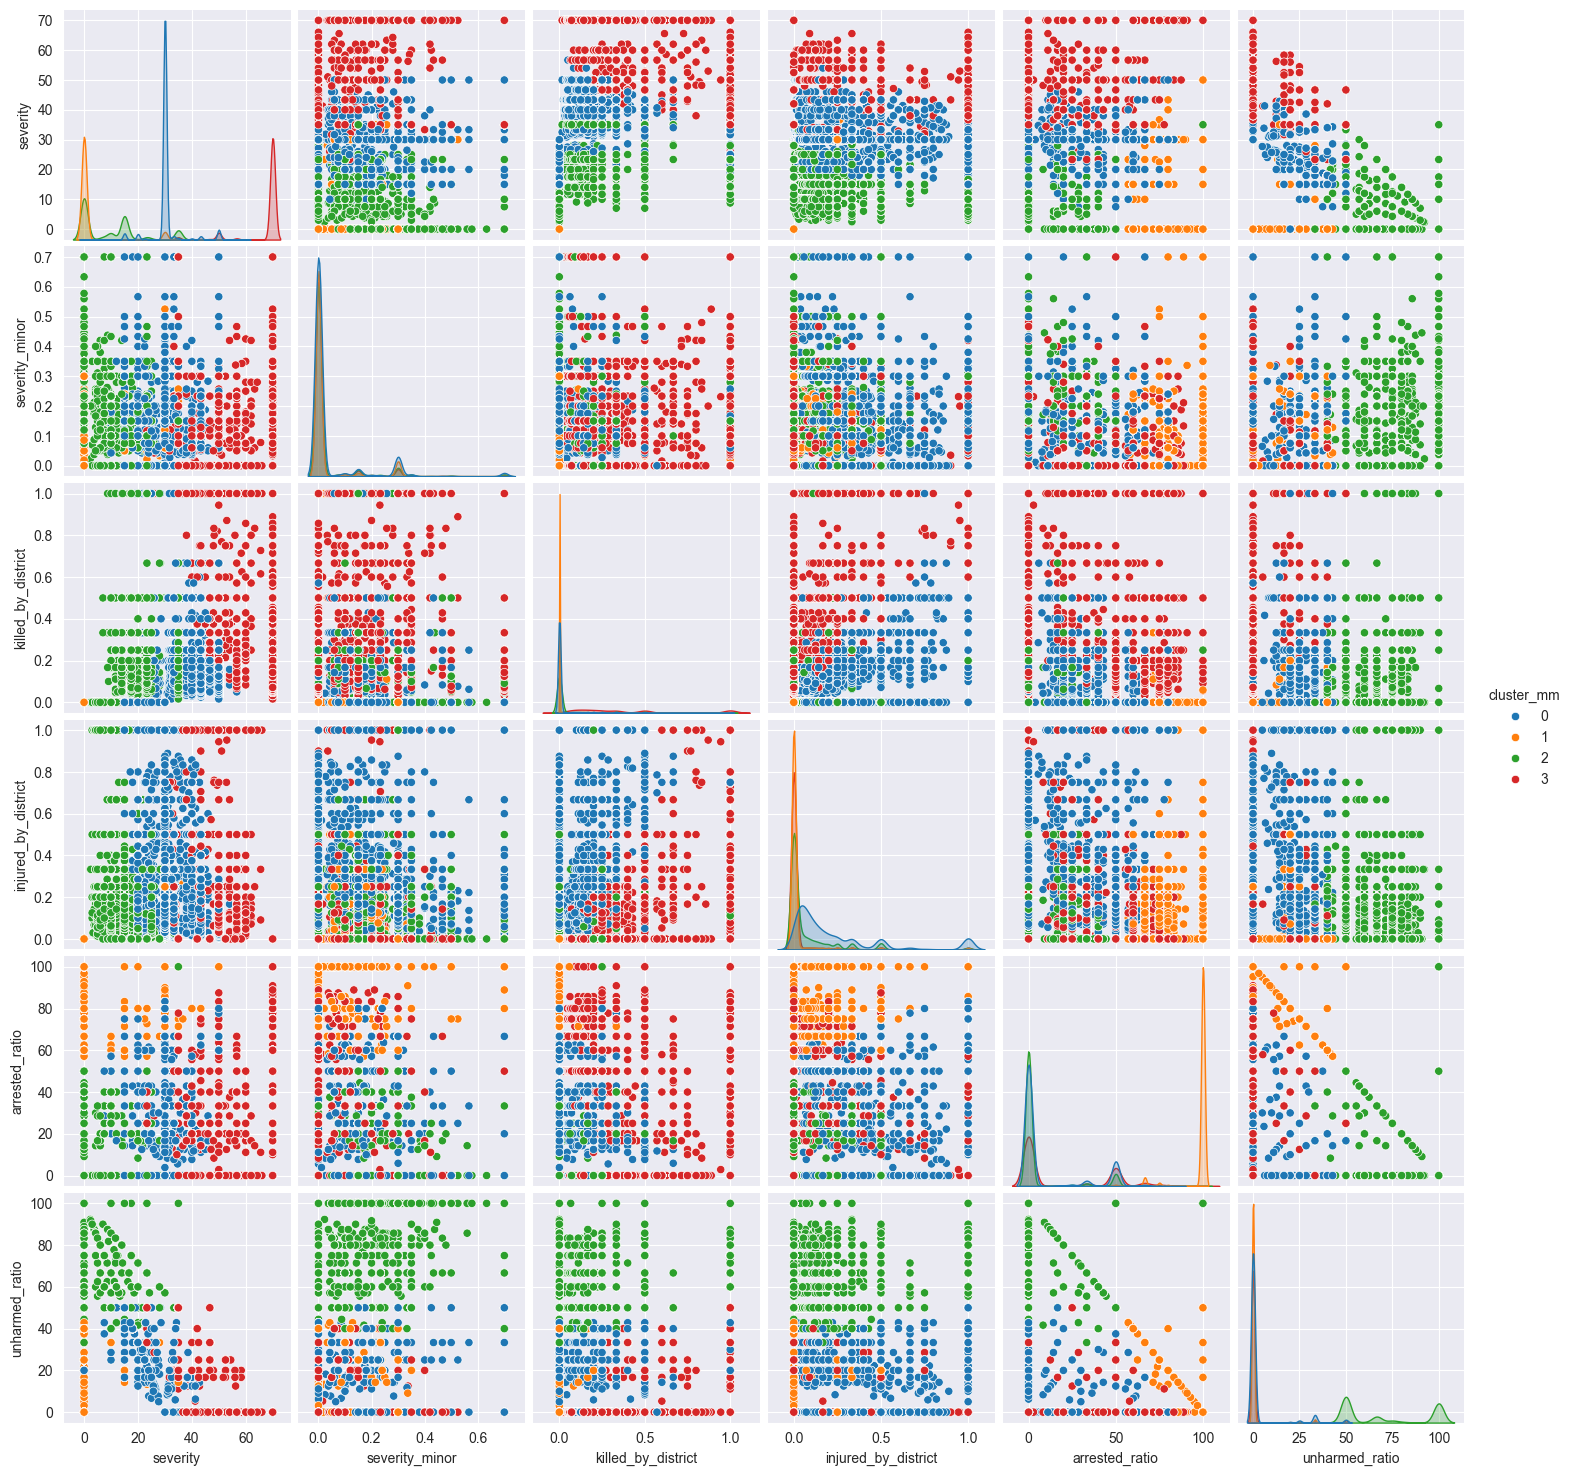

In [39]:
feature_scatter = [
    'severity', 
    'severity_minor',
    'killed_by_district',
    'injured_by_district',
    'arrested_ratio',
    'unharmed_ratio',
    'cluster_mm'
]
sns.pairplot(df_incidents_clustering[feature_scatter], hue='cluster_mm', palette=sns.color_palette(n_colors=4))
plt.show()

Let's see the distribution of killed people in the 4 clusters obtained with StandardScaler and MinMaxScaler. This could be useful to understand if the clusters capture different types of incidents.

In [40]:
df_incidents.shape

(161550, 34)

In [41]:
df_incidents_clustering.shape

(161550, 11)

In [42]:
# To do this analysis, we need to add back the feature `n_killed`
df_incidents_clustering['n_killed'] = df_incidents['n_killed']

In [43]:
df_incidents_clustering.columns

Index(['avg_age_participants', 'povertyPercentage', 'severity',
       'severity_minor', 'killed_by_district', 'injured_by_district',
       'arrested_ratio', 'unharmed_ratio', 'right_or_left', 'cluster',
       'cluster_mm', 'n_killed'],
      dtype='object')

In [53]:
# see the values of cluster_kmeans_mm
df_incidents_clustering['cluster'].value_counts()

cluster
1    55127
2    36400
3    35655
0    34368
Name: count, dtype: int64

In [46]:
# see the values of cluster_kmeans_mm
df_incidents_clustering['cluster_mm'].value_counts()

cluster_mm
0    52154
2    39153
3    35171
1    35072
Name: count, dtype: int64

Cluster 0: 15 killed over 51271 total killed people
Cluster 1: 5318 killed over 51271 total killed people
Cluster 2: 4783 killed over 51271 total killed people
Cluster 3: 41155 killed over 51271 total killed people


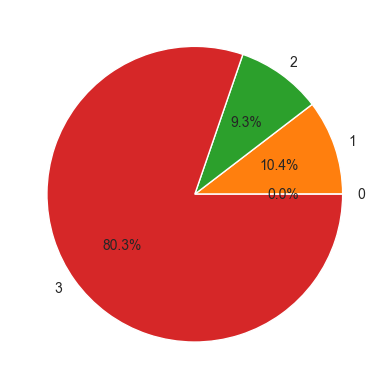

In [54]:
for k in range(4):
    killed_per_cluster = df_incidents_clustering[df_incidents_clustering['cluster']==k]['n_killed'].sum()
    print('Cluster {}: {} killed'.format(k, killed_per_cluster), 'over', df_incidents_clustering['n_killed'].sum(), 'total killed people')
# pie plot to see the percentage of killed people in each cluster
plt.pie(df_incidents_clustering.groupby('cluster')['n_killed'].sum(), labels=['0', '1', '2', '3'], autopct='%1.1f%%')
plt.show()

Cluster 0: 4601 killed over 51271 total killed people
Cluster 1: 33 killed over 51271 total killed people
Cluster 2: 5930 killed over 51271 total killed people
Cluster 3: 40707 killed over 51271 total killed people


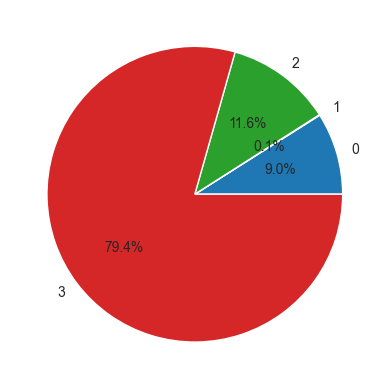

In [55]:
for k in range(4):
    killed_per_cluster_mm = df_incidents_clustering[df_incidents_clustering['cluster_mm']==k]['n_killed'].sum()
    print('Cluster {}: {} killed'.format(k, killed_per_cluster_mm), 'over', df_incidents_clustering['n_killed'].sum(), 'total killed people')
# pie plot to see the percentage of killed people in each cluster
plt.pie(df_incidents_clustering.groupby('cluster_mm')['n_killed'].sum(), labels=['0', '1', '2', '3'], autopct='%1.1f%%')
plt.show()

We can notice that in both cases the majority of killed people is in the cluster 3. This could mean that the cluster 3 captures the most severe incidents. On the other hand the percentages of killed people in the clusters 0 and 1 are almost inverted.

In [62]:
# Let's see the distributions of other features in the clusters 0, 1
print(
    '\n',
    df_incidents_clustering[df_incidents_clustering['cluster']==0].unharmed_ratio.mean(),
    '\n',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==0].unharmed_ratio.mean(),
    '\n',
    df_incidents_clustering[df_incidents_clustering['cluster']==0].injured_by_district.mean(),
    '\n',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==0].injured_by_district.mean(),
    '\n',
    '\n',
    df_incidents_clustering[df_incidents_clustering['cluster']==1].unharmed_ratio.mean(),
    '\n',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==1].unharmed_ratio.mean(),
    '\n',
    df_incidents_clustering[df_incidents_clustering['cluster']==1].injured_by_district.mean(),
    '\n',
    df_incidents_clustering[df_incidents_clustering['cluster_mm']==1].injured_by_district.mean()
)


 0.7620367826975906 
 2.6634215513769615 
 0.008942333076277384 
 0.23622540772107292 
 
 4.082703839763474 
 0.757636376736247 
 0.24550249966225063 
 0.01919176594076088


We can notice that the clusters 0 and 1 for the K-means with StandardScaler and MinMaxScaler have very similar values for the features `injured_by_district`, but they are almost inverted for `unharmed_ratio`. This could be the reason why the pie plot of the killed people is almost inverted for the two cases.

### Analysis of the clusters

#### Incidents' characteristics per cluster

<Axes: xlabel='cluster_kmeans', ylabel='count'>

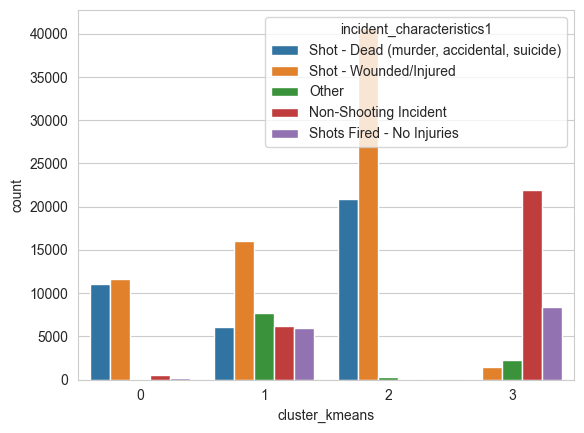

In [109]:
#let's see the distribution of the feature "incident_characteristcs1" in the clusters
sns.countplot(data=df_incidents, x='cluster_kmeans', hue='incident_characteristics1')


We notice that the 0-th and 3rd clusters capture shooting incidents with injured and/or deaths. 
The 1st one captures mostly non-shooting incidents and a certain amount of no injured type.  3 of the 4 clusters seem to have captured three different types of incidents, while the fourth cluster is a mix of the other three. We also notice how the characteristics of `shots fires - no injuries` and `non shooting accident` may be very similar, because the majority of them is in the same cluster.

#### KDE of the features for each cluster

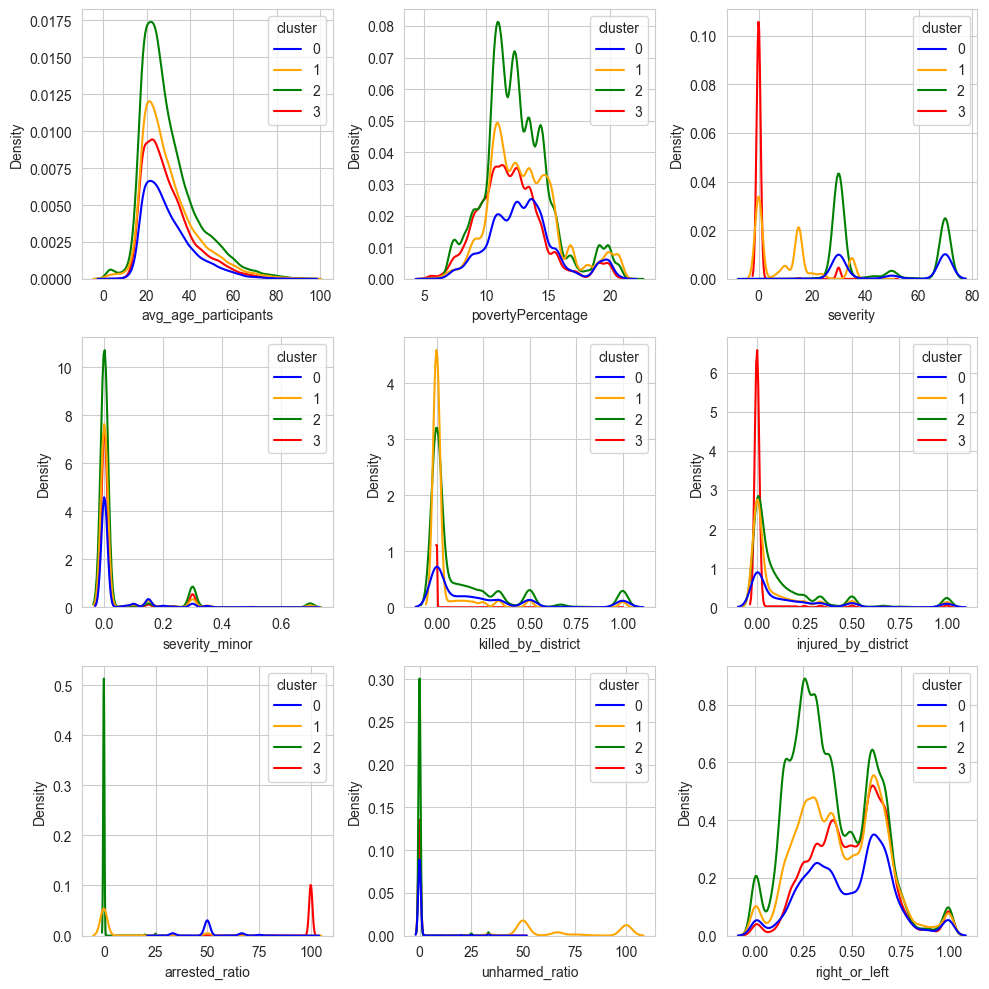

In [110]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_incidents_clustering.columns.drop(['cluster'])):
    sns.kdeplot(df_incidents_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red'])

plt.tight_layout()
plt.show()

We see that some features are more discriminative than others. For example, the feature `severity` is very discriminative: at least three of the four clusters have very different modes.
 Instead `povertyPercentage` is not. This could lead to think that the poverty percentage of the area is not a good indicator for  the specifics severity of single incidents. The attribute could be more important in an aggregated framework, where we do not consider the single incidents, but the number of incidents in a certain area.

### Validating the clusters

#### SSE score

In [114]:
kmeans.inertia_/ df_incidents_scaled.shape[0]

627.3332899017477

#### Silhouette score
We compute the silhouette score for the clusters obtained with k-means. We subsample the dataset because the computation is too expensive.

In [112]:
from sklearn.metrics import silhouette_score
silhouette_score(df_incidents_scaled, df_incidents_clustering['cluster'], sample_size=10000)


0.1755267057282932

The silhouette score is not very high, but it is not negative, so we can say that the clusters are not too bad. Still, this could indicate that there are not well-defined natural clusters in the dataset.
We also compute the Calinski-Harabasz score, which is another metric to evaluate the goodness of the clusters.
The metric is defined as the ratio between the within-cluster dispersion and the between-cluster dispersion. The higher the score, the better the clusters.
The within-cluster dispersion is defined as the sum of the squared distances between each point and the centroid of its cluster. The between-cluster dispersion is defined as the sum of the squared distances between the centroids of the clusters and the centroid of the whole dataset.

#### Calinski-Harabasz score

In [113]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(df_incidents_scaled, df_incidents['cluster_kmeans'])

22560.04179457279

#### Matrix of pairwise distances
We define the matrix of pairwise distance as $D=(D_{ij})$, where $D_{ij}$ is the distance between the $i$-th and $j$-th points.
Unfortunately, due to the size of the dataset, the whole matrix is impossible to compute. We subsample the dataset and compute the pairwise distances on the subsample.

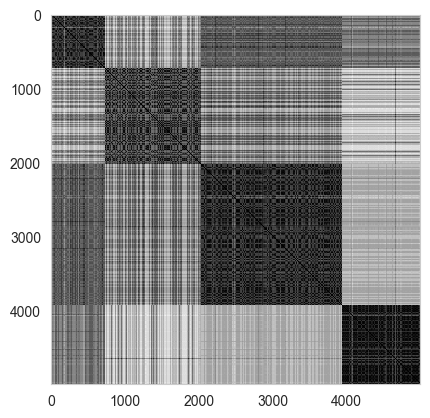

In [132]:
from sklearn.metrics import pairwise_distances
# subset the dataset
df_incidents_clustering_subset = df_incidents_clustering.sample(5000)
# order the subset by cluster label
df_incidents_clustering_subset = df_incidents_clustering_subset.sort_values(by='cluster')
# compute the pairwise distances
distances = pairwise_distances(df_incidents_clustering_subset)
plt.imshow(distances, cmap='gray', interpolation='none')
# turn off grid lines
plt.grid(False)

We define the optimal clustering matrix as $A=(A_{ij})$, where $A_{ij}=0$ if $i$ and $j$ are in the same cluster, $A_{ij}=1$ otherwise.
We can compute the correlation between the two matrices $D$ and $A$.

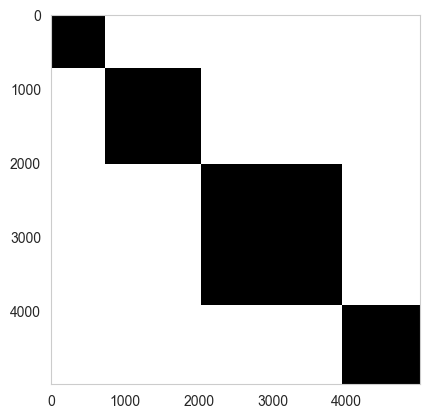

In [133]:
# define optimal distance matrix as 0 if the two points are in the same cluster, 1 otherwise
optimal_distances = np.ones(distances.shape)
# locate the indices of the points in the same cluster
same_cluster_indices = np.where(df_incidents_clustering_subset['cluster'].values.reshape(-1,1) == df_incidents_clustering_subset['cluster'].values.reshape(1,-1))

# set the optimal distance to 0
optimal_distances[same_cluster_indices] = 0
plt.imshow(optimal_distances, cmap='gray', interpolation='none')
plt.grid(False)

#correlation between the two matrices
np.corrcoef(distances.reshape(-1), optimal_distances.reshape(-1))

The distance matrix and the optimal matrix are fairly correlated. This can mean that the clusters are well-defined.

### Second try

In [17]:
cols_to_keep = ['avg_age_participants', 'povertyPercentage',
       'severity', 'severity_minor', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']

In [18]:
df_incidents_clustering2 = df_incidents[cols_to_keep]


In [19]:
#pca
scaler = StandardScaler()
df_incidents_scaled2 = scaler.fit_transform(df_incidents_clustering2)
df_incidents_scaled2 = pd.DataFrame(df_incidents_scaled2, columns=df_incidents_clustering2.columns)

df_incidents_pca2 = pca.fit_transform(df_incidents_scaled2)

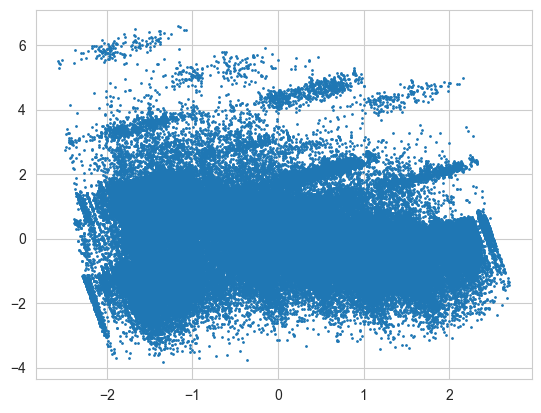

In [20]:
plt.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], s=1)

In [21]:
# elbow method to find the optimal number of clusters
kmeans=[]
SSE = []
for i in range(1, 11):
    kmeans.append( KMeans(n_clusters=i, random_state=0, n_init=1).fit(df_incidents_scaled2) )
    SSE.append(kmeans[i-1].inertia_)

([<matplotlib.axis.XTick at 0x24010723dc0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

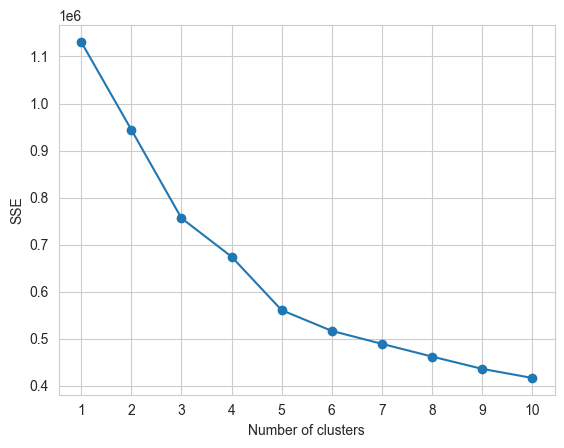

In [22]:
plt.plot( range(1,11),SSE, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
# change numbers on x axis
plt.xticks(np.arange(1, 11, step=1))

In [23]:
#we choose 5 clusters
kmeans = KMeans(n_clusters=5, random_state=0, n_init=10).fit(df_incidents_scaled2)
df_incidents['cluster_kmeans2'] = kmeans.labels_
df_incidents['cluster_kmeans2'].value_counts()
df_incidents_clustering2['cluster'] = kmeans.labels_

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\2996236691.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incidents_clustering2['cluster'] = kmeans.labels_


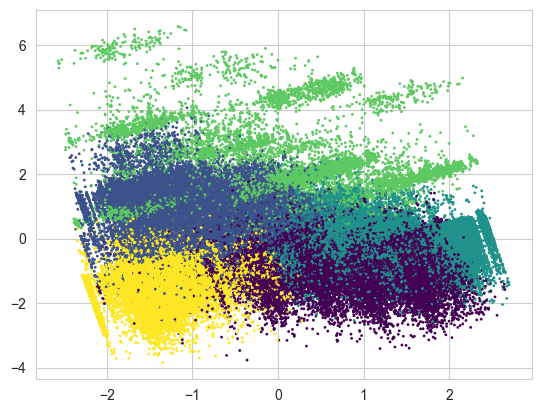

In [24]:
#plot 2d
plt.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], c=df_incidents_clustering2['cluster'], s=1, cmap='viridis')

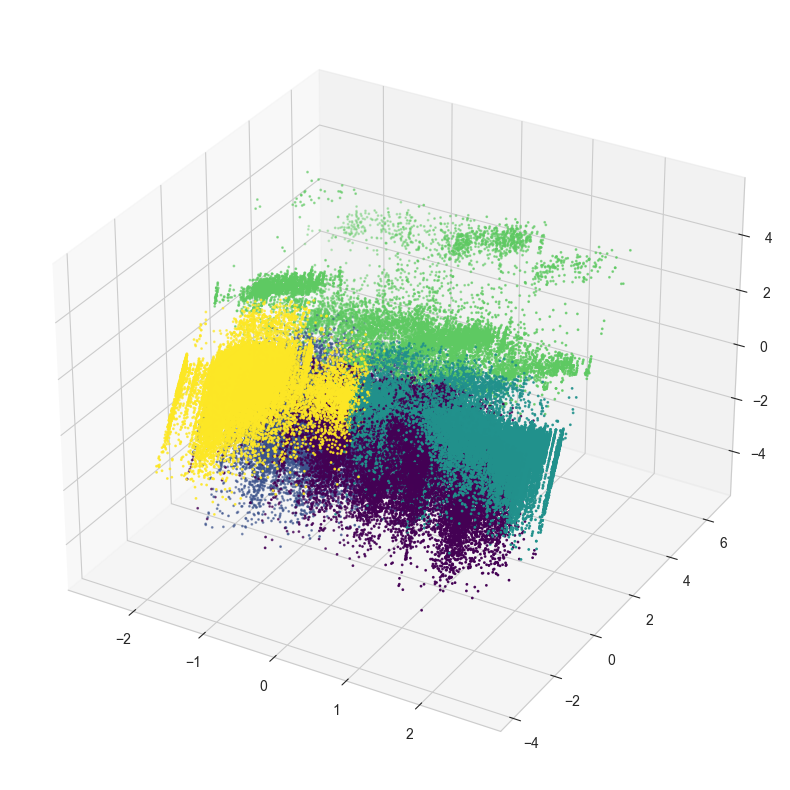

In [25]:
#plot 3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pca= PCA(n_components=3)
df_incidents_pca2 = pca.fit_transform(df_incidents_scaled2)
ax.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], df_incidents_pca2[:,2], c=df_incidents_clustering2['cluster'], s=1, cmap='viridis')


<Axes: xlabel='cluster_kmeans2', ylabel='count'>

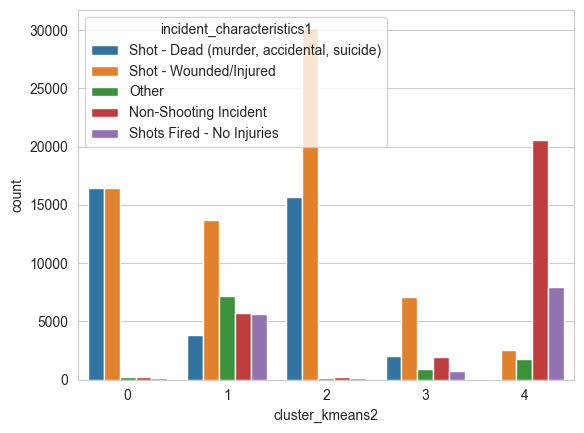

In [26]:
sns.countplot(data=df_incidents, x='cluster_kmeans2', hue='incident_characteristics1')

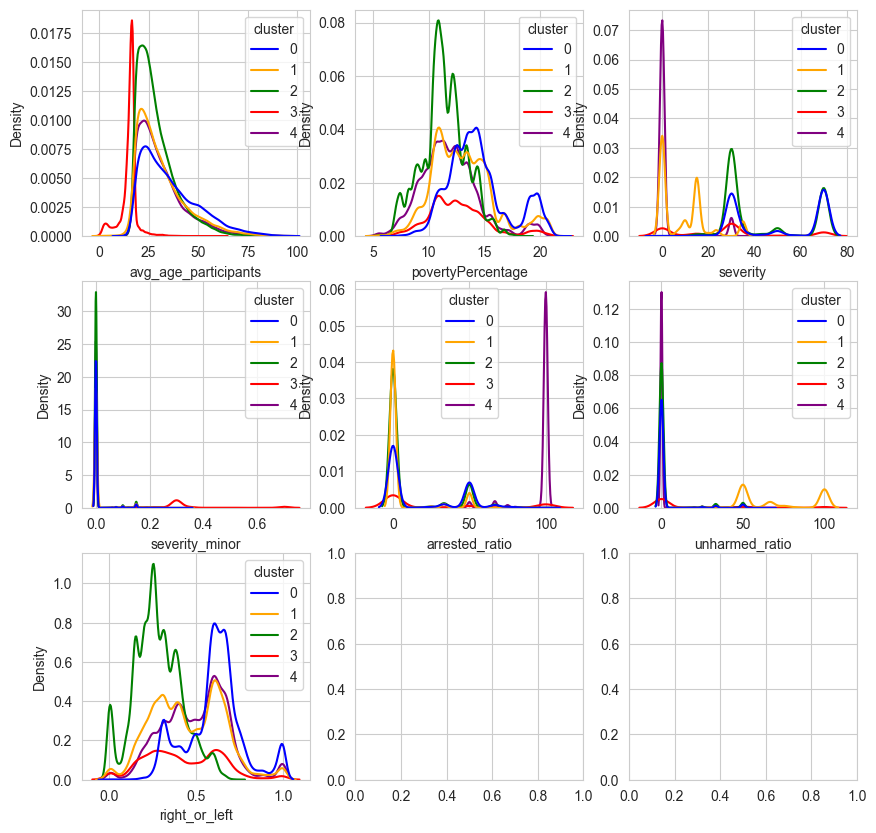

In [27]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_incidents_clustering2.columns.drop(['cluster'])):
    sns.kdeplot(df_incidents_clustering2, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple'])

In [28]:
# k = 6
kmeans = KMeans(n_clusters=6, random_state=0, n_init=10).fit(df_incidents_scaled2)
df_incidents['cluster_kmeans2'] = kmeans.labels_
df_incidents['cluster_kmeans2'].value_counts()
df_incidents_clustering2['cluster'] = kmeans.labels_

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\918048727.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_incidents_clustering2['cluster'] = kmeans.labels_


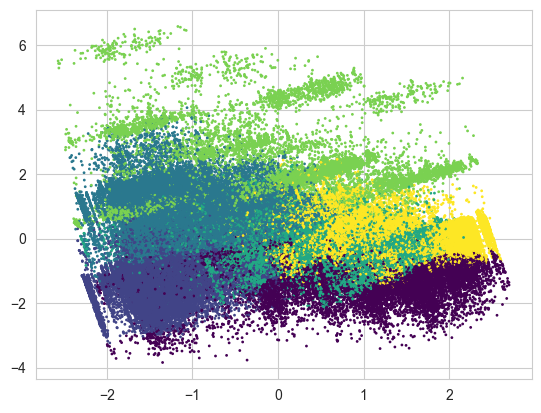

In [29]:
#plot 2d
plt.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], c=df_incidents_clustering2['cluster'], s=1, cmap='viridis')

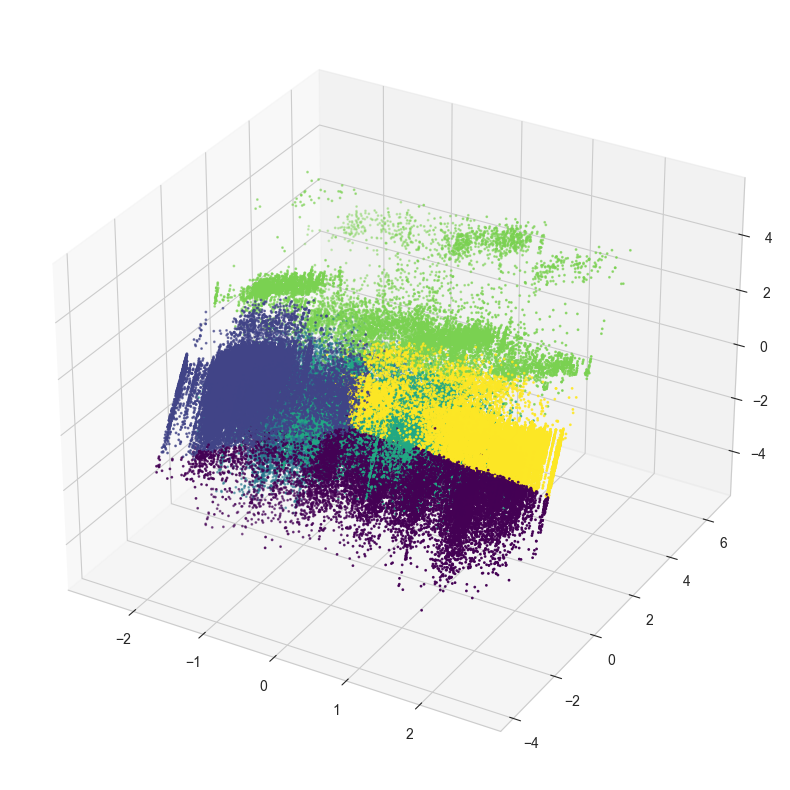

In [30]:
#plot 3d
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
pca= PCA(n_components=3)
df_incidents_pca2 = pca.fit_transform(df_incidents_scaled2)
ax.scatter(df_incidents_pca2[:,0], df_incidents_pca2[:,1], df_incidents_pca2[:,2], c=df_incidents_clustering2['cluster'], s=1, cmap='viridis')

<Axes: xlabel='cluster_kmeans2', ylabel='count'>

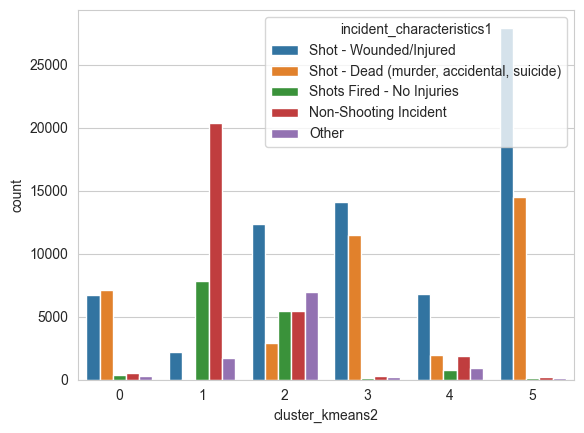

In [31]:
sns.countplot(data=df_incidents, x='cluster_kmeans2', hue='incident_characteristics1')

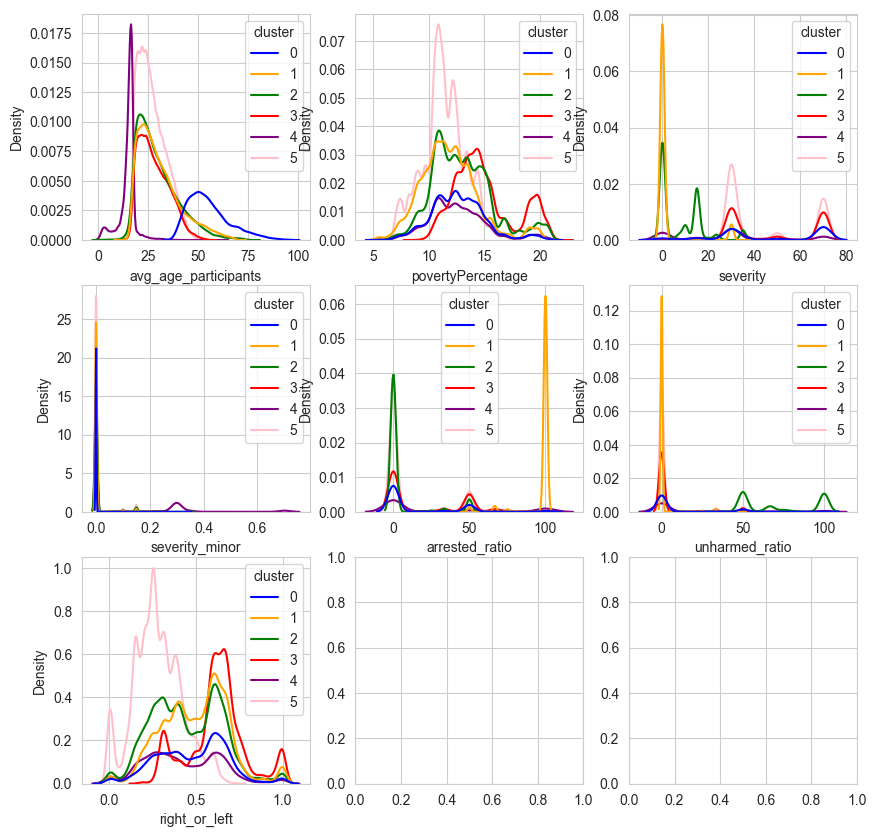

In [32]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_incidents_clustering2.columns.drop(['cluster'])):
    sns.kdeplot(df_incidents_clustering2, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])


## k- Means on single states
We take the most populated state: California, and the poorest and richest states: Mississippi and New Hampshire.

In [33]:
df_ca = df_incidents[df_incidents['state']=='california']
df_ms = df_incidents[df_incidents['state']=='mississippi']
df_nh = df_incidents[df_incidents['state']=='new hampshire']

In [34]:
cols_for_clustering =['avg_age_participants', 'povertyPercentage',
        'severity', 'severity_minor', 'killed_by_district',
       'injured_by_district', 'arrested_ratio', 'unharmed_ratio',
       'right_or_left']

In [35]:
df_ca_clustering = df_ca[cols_for_clustering]
df_ms_clustering = df_ms[cols_for_clustering]
df_nh_clustering = df_nh[cols_for_clustering]


In [36]:
#pca
scaler = StandardScaler()
df_ca_scaled = scaler.fit_transform(df_ca_clustering)
df_ca_scaled = pd.DataFrame(df_ca_scaled, columns=df_ca_clustering.columns)
df_ms_scaled = scaler.fit_transform(df_ms_clustering)
df_ms_scaled = pd.DataFrame(df_ms_scaled, columns=df_ms_clustering.columns)
df_nh_scaled = scaler.fit_transform(df_nh_clustering)
df_nh_scaled = pd.DataFrame(df_nh_scaled, columns=df_nh_clustering.columns)

In [37]:
#pca of the three states
pca = PCA(n_components=2)
df_ca_pca = pca.fit_transform(df_ca_scaled)
df_ms_pca = pca.fit_transform(df_ms_scaled)
df_nh_pca = pca.fit_transform(df_nh_scaled)

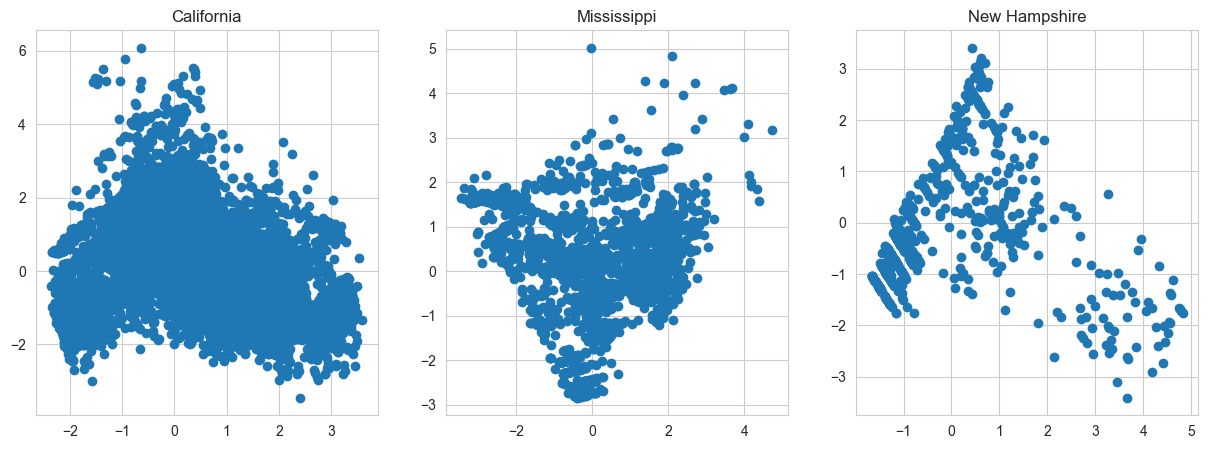

In [38]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(df_ca_pca[:,0], df_ca_pca[:,1])
ax[1].scatter(df_ms_pca[:,0], df_ms_pca[:,1])
ax[2].scatter(df_nh_pca[:,0], df_nh_pca[:,1])
ax[0].set_title('California')
ax[1].set_title('Mississippi')
ax[2].set_title('New Hampshire')

plt.show()


### elbow method to find the optimal number of clusters

In [39]:

kmeans_ca=[]
SSE_ca = []
for i in range(1, 11):
    kmeans_ca.append( KMeans(n_clusters=i, random_state=0, n_init=5).fit(df_ca_scaled) )
    SSE_ca.append(kmeans_ca[i-1].inertia_)

In [40]:

kmeans_ms=[]
SSE_ms = []
for i in range(1, 11):
    kmeans_ms.append( KMeans(n_clusters=i, random_state=0, n_init=5).fit(df_ms_scaled) )
    SSE_ms.append(kmeans_ms[i-1].inertia_)

In [41]:
kmeans_nh=[]
SSE_nh = []
for i in range(1, 11):
    kmeans_nh.append( KMeans(n_clusters=i, random_state=0, n_init=5).fit(df_nh_scaled) )
    SSE_nh.append(kmeans_nh[i-1].inertia_)


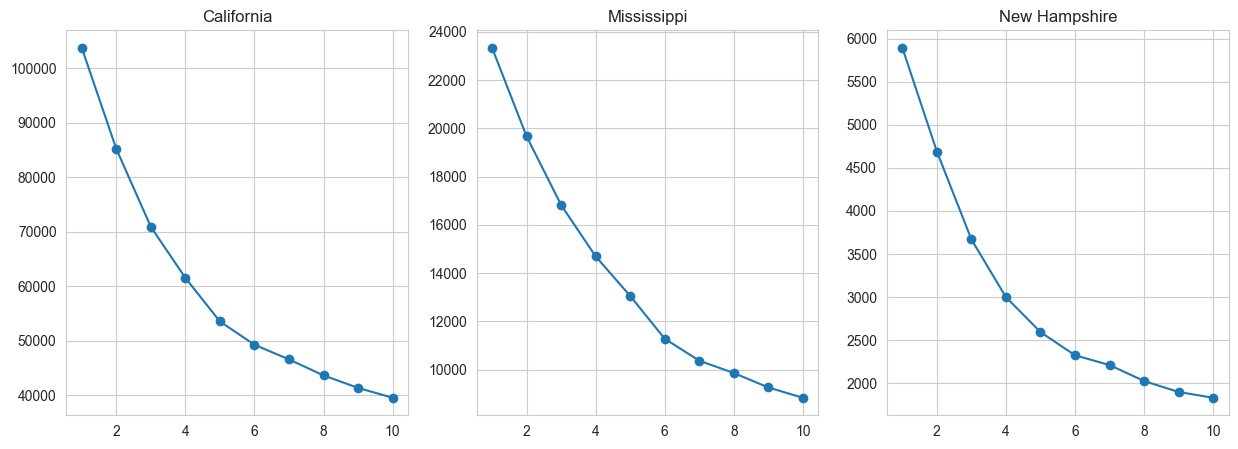

In [42]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].plot( range(1,11),SSE_ca, marker='o')
ax[1].plot( range(1,11),SSE_ms, marker='o')
ax[2].plot( range(1,11),SSE_nh, marker='o')
ax[0].set_title('California')
ax[1].set_title('Mississippi')
ax[2].set_title('New Hampshire')
plt.show()


In [43]:
#we choose 6 clusters for all the three states
kmeans_ca = KMeans(n_clusters=6, random_state=0, n_init=10).fit(df_ca_scaled)
df_ca['cluster_kmeans'] = kmeans_ca.labels_
df_ca['cluster_kmeans'].value_counts()
df_ca_clustering['cluster'] = kmeans_ca.labels_

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\3903020895.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_kmeans'] = kmeans_ca.labels_
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\3903020895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca_clustering['cluster'] = kmeans_ca.labels_


In [44]:

kmeans_ms = KMeans(n_clusters=6, random_state=0, n_init=10).fit(df_ms_scaled)
df_ms['cluster_kmeans'] = kmeans_ms.labels_
df_ms['cluster_kmeans'].value_counts()
df_ms_clustering['cluster'] = kmeans_ms.labels_

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\2943523862.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms['cluster_kmeans'] = kmeans_ms.labels_
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\2943523862.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ms_clustering['cluster'] = kmeans_ms.labels_


In [45]:

kmeans_nh = KMeans(n_clusters=4, random_state=0, n_init=10).fit(df_nh_scaled)
df_nh['cluster_kmeans'] = kmeans_nh.labels_
df_nh['cluster_kmeans'].value_counts()
df_nh_clustering['cluster'] = kmeans_nh.labels_


C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\2427694601.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nh['cluster_kmeans'] = kmeans_nh.labels_
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\2427694601.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nh_clustering['cluster'] = kmeans_nh.labels_


2D plots of the 3 states

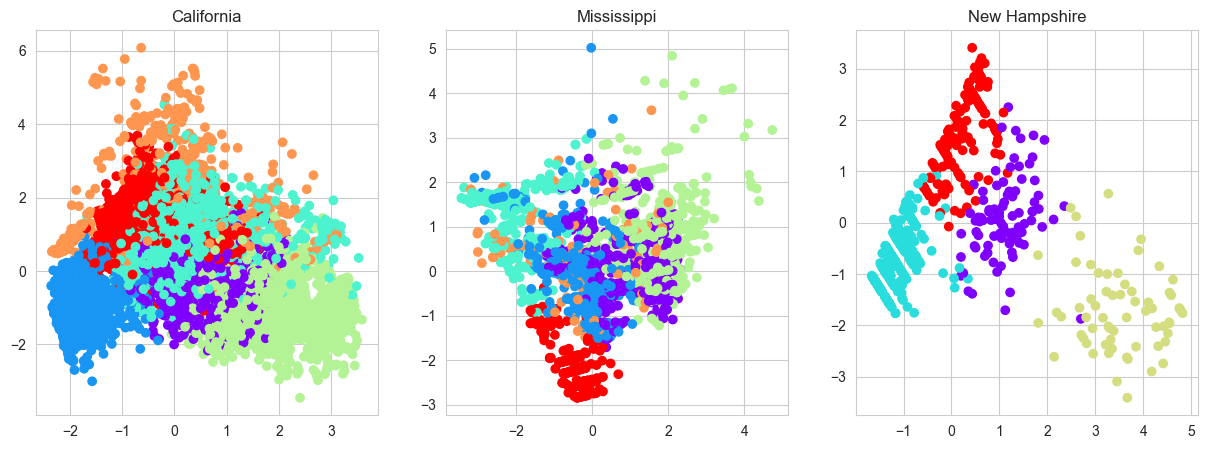

In [46]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca_clustering['cluster'], cmap='rainbow')
ax[1].scatter(df_ms_pca[:,0], df_ms_pca[:,1], c=df_ms_clustering['cluster'], cmap='rainbow')
ax[2].scatter(df_nh_pca[:,0], df_nh_pca[:,1], c=df_nh_clustering['cluster'], cmap= 'rainbow')
ax[0].set_title('California')
ax[1].set_title('Mississippi')
ax[2].set_title('New Hampshire')
plt.show()


In [47]:
#3D plot 

pca= PCA(n_components=3)
df_ca_pca = pca.fit_transform(df_ca_scaled)
df_ms_pca = pca.fit_transform(df_ms_scaled)
df_nh_pca = pca.fit_transform(df_nh_scaled)

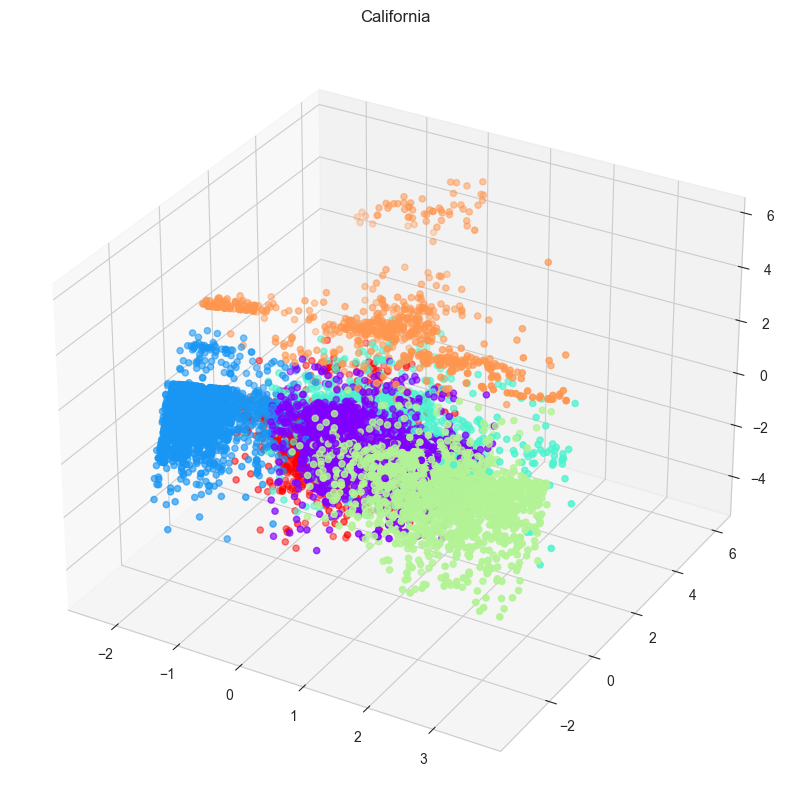

In [48]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('California')
ax.scatter(df_ca_pca[:,0], df_ca_pca[:,1], df_ca_pca[:,2], c=df_ca_clustering['cluster'], cmap='rainbow')

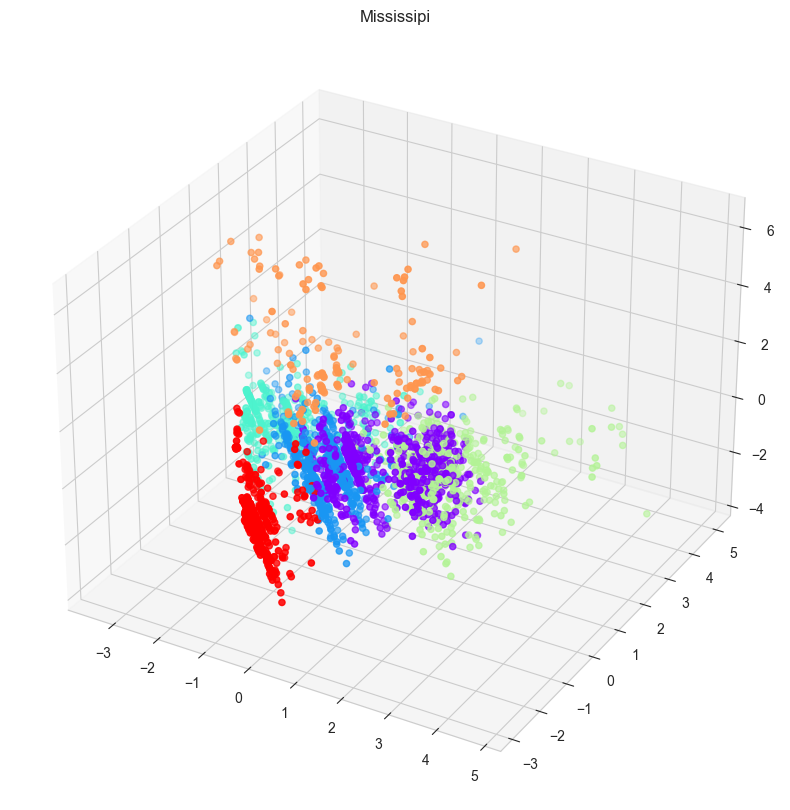

In [49]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Mississipi')
ax.scatter(df_ms_pca[:,0], df_ms_pca[:,1], df_ms_pca[:,2], c=df_ms_clustering['cluster'],  cmap='rainbow')


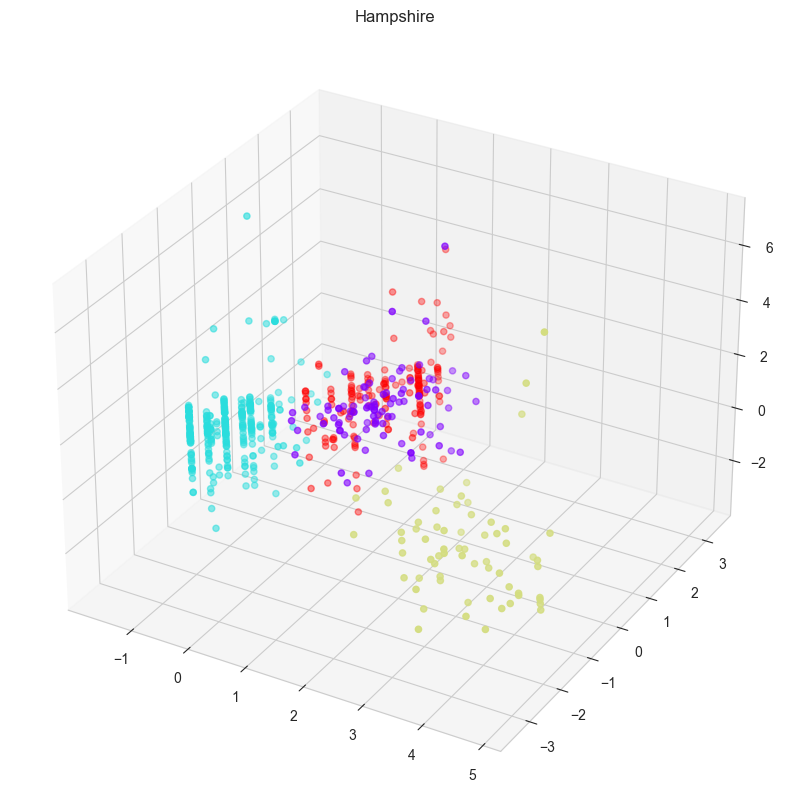

In [50]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Hampshire')
ax.scatter(df_nh_pca[:,0], df_nh_pca[:,1], df_nh_pca[:,2], c=df_nh_clustering['cluster'],  cmap='rainbow')


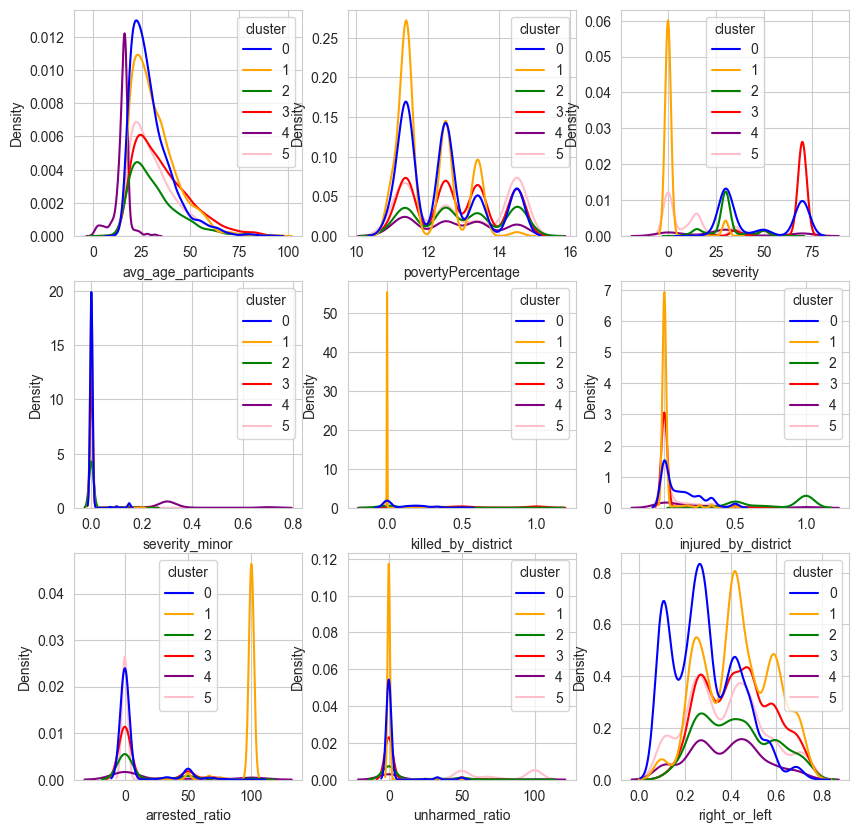

In [51]:
# KDE of the features for each cluster
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_ca_clustering.columns.drop(['cluster'])):
    sns.kdeplot(df_ca_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\1634919963.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_ms_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])


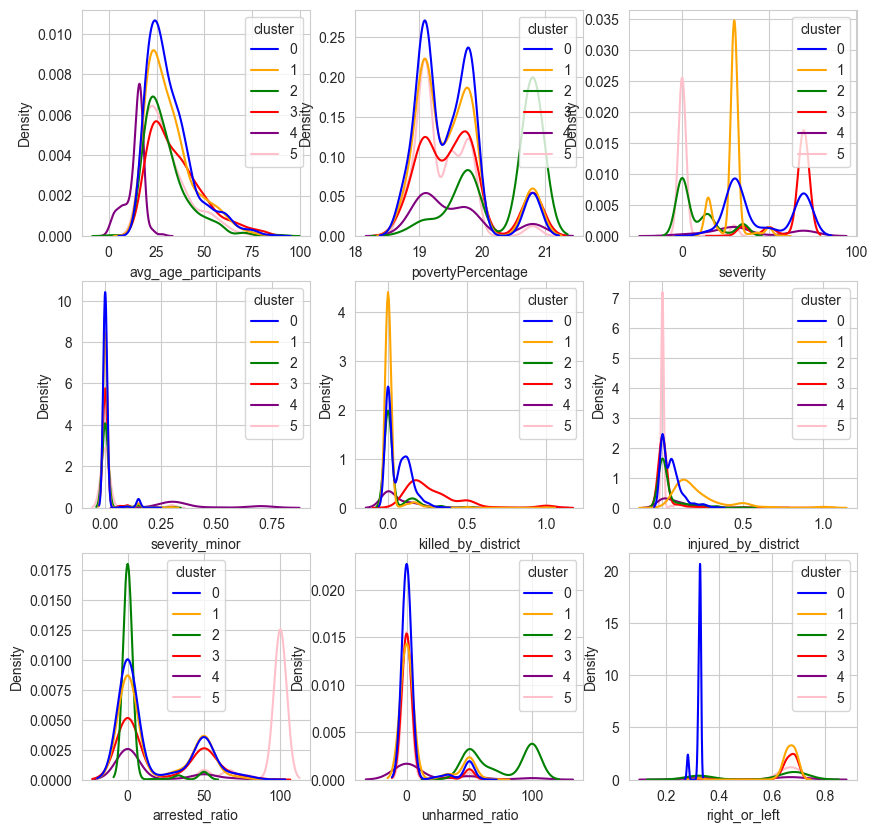

In [52]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_ms_clustering.columns.drop(['cluster'])):
    sns.kdeplot(df_ms_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red', 'purple', 'pink'])

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\2596455366.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_nh_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red'])
C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\2596455366.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df_nh_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red'])


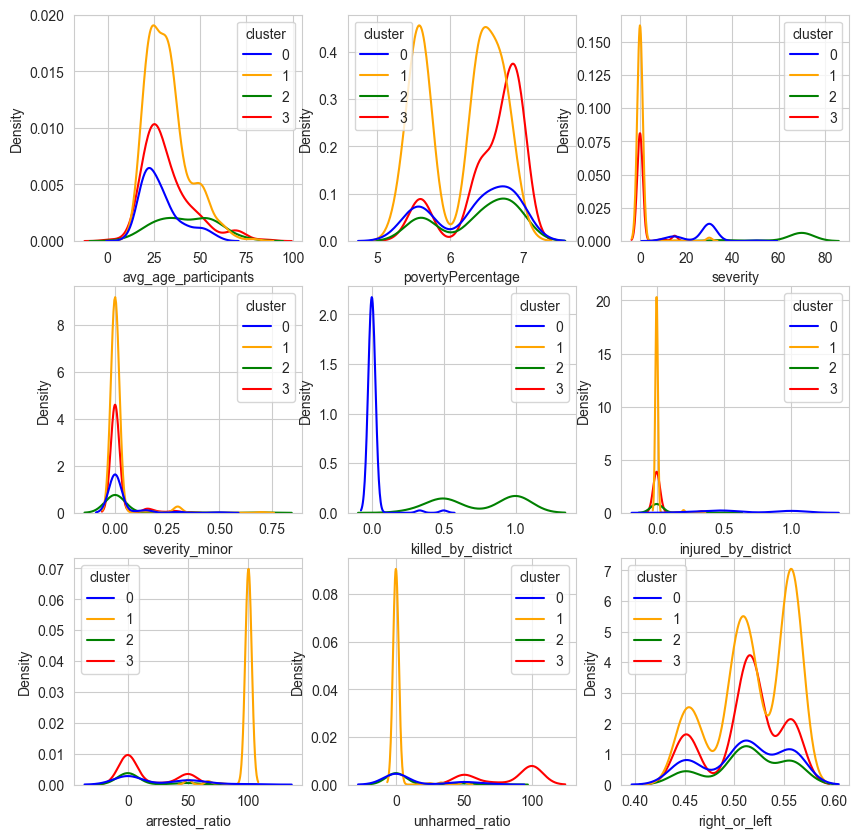

In [53]:
fig, axs = plt.subplots(3, 3, figsize=(10,10))
for i, col in enumerate(df_nh_clustering.columns.drop(['cluster'])):
    sns.kdeplot(df_nh_clustering, x=col, hue='cluster',  ax=axs[i // 3, i % 3], palette=['blue', 'orange', 'green', 'red'])

## DBSCAN

In [54]:
from sklearn.cluster import DBSCAN

In [55]:
#we drop some columns we consider as less significant: "poverty_percentage", "arrested_ratio",
#"unharmed_ratio" 
cols_for_clustering =['avg_age_participants', 
        'severity', 'severity_minor', 'killed_by_district',
       'injured_by_district', 'right_or_left']

df_incidents_clustering = df_incidents[cols_for_clustering]

In [56]:
df_ca = df_incidents[df_incidents['state']=='california']
df_ca_clustering = df_ca[cols_for_clustering]

In [57]:
df_ca_scaled = scaler.fit_transform(df_ca_clustering)

In [58]:
#pca
pca = PCA(n_components=2)
df_ca_pca = pca.fit_transform(df_ca_scaled)


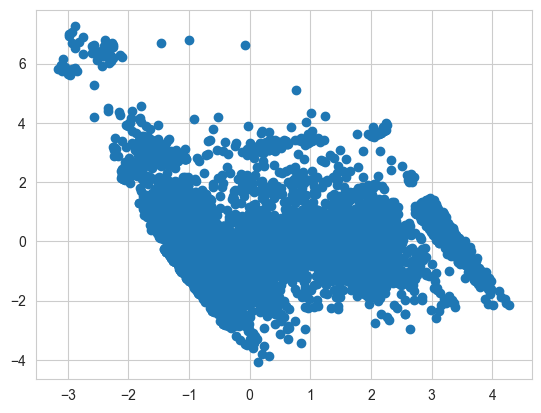

In [59]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1])

### Selecting the k and epsilon plotting the k-distance graph

 We run k-nn for k from 1 to 20 to visually choose our parameters

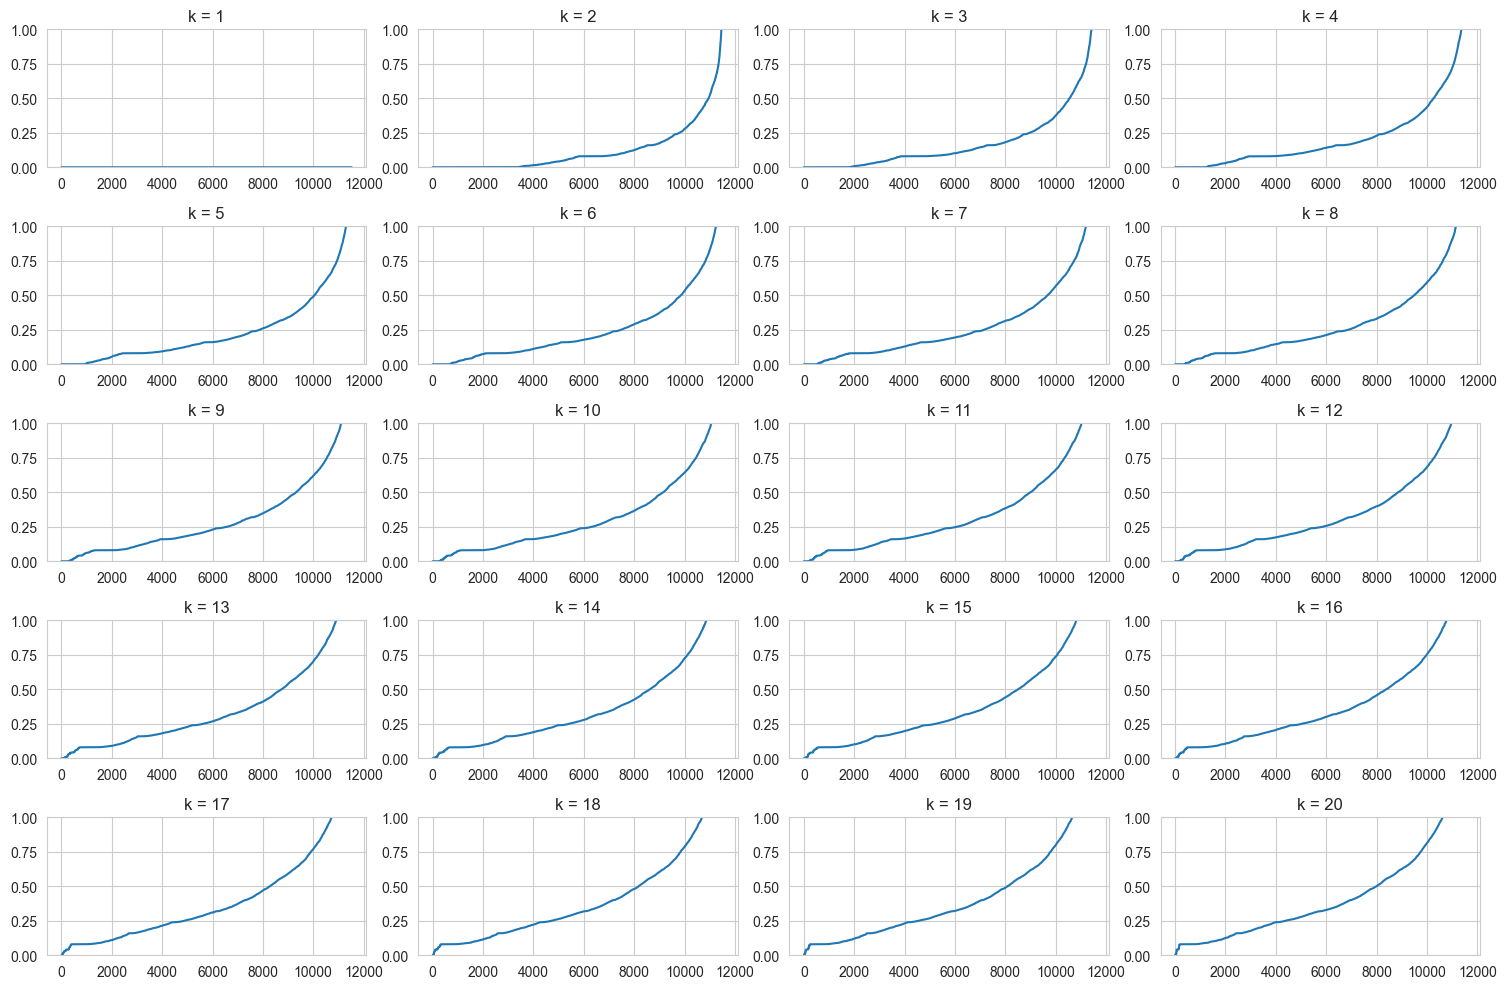

In [60]:
from sklearn.neighbors import NearestNeighbors
max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_ca_scaled)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_ca_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])
plt.tight_layout()

We pick the number of points min_samples=5 and radius eps=0.85 

In [61]:
dbscan= DBSCAN(eps=0.85, min_samples=5).fit(df_ca_scaled)
df_ca['cluster_dbscan'] = dbscan.labels_
df_ca['cluster_dbscan'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\891136902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_dbscan'] = dbscan.labels_


 0    11086
-1      235
 2       48
 1       45
 4       42
 3       26
 6       19
 9       10
 7        6
 5        6
 8        5
Name: cluster_dbscan, dtype: int64

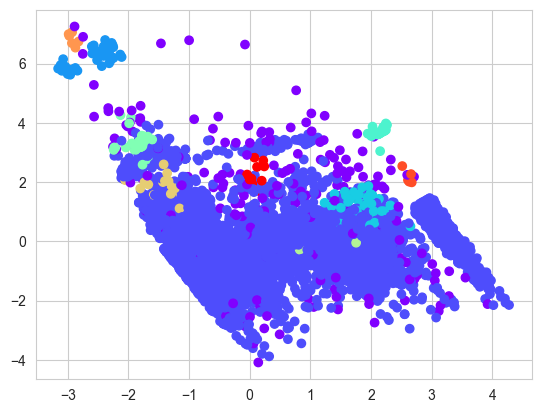

In [62]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca['cluster_dbscan'], cmap='rainbow')

In [63]:
#plot 3d
pca= PCA(n_components=3)
df_ca_pca = pca.fit_transform(df_ca_scaled)

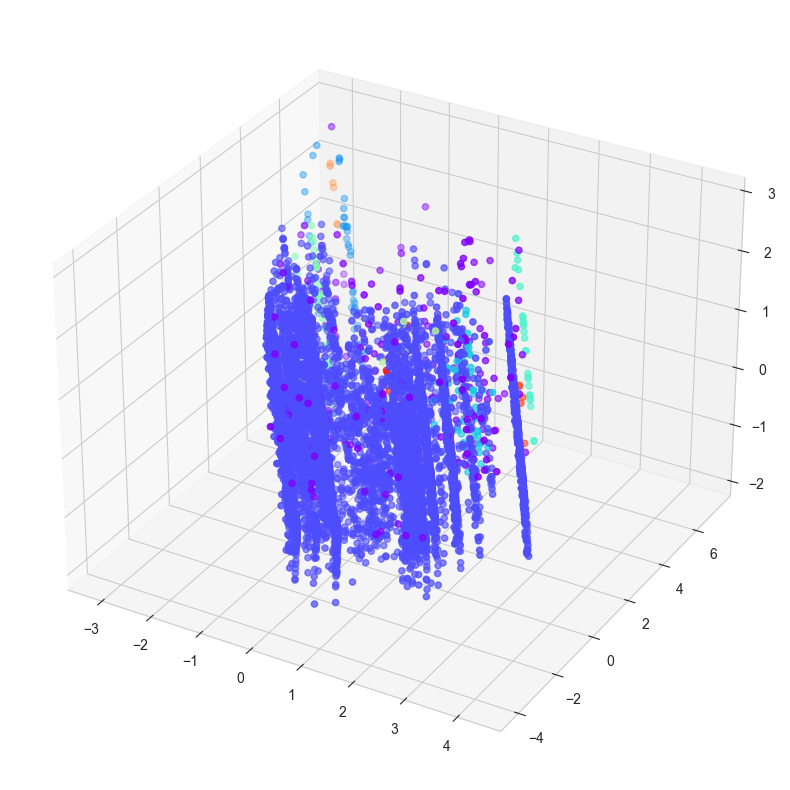

In [64]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_ca_pca[:,0], df_ca_pca[:,1], df_ca_pca[:,2], c=df_ca['cluster_dbscan'], cmap='rainbow')

### Let's repeat the same process for the state of Florida

In [65]:
df_fl = df_incidents[df_incidents['state']=='florida']
df_fl_clustering = df_fl[cols_for_clustering]

In [66]:
df_fl_scaled = scaler.fit_transform(df_fl_clustering)

In [67]:
#pca
pca = PCA(n_components=2)
df_fl_pca = pca.fit_transform(df_fl_scaled)


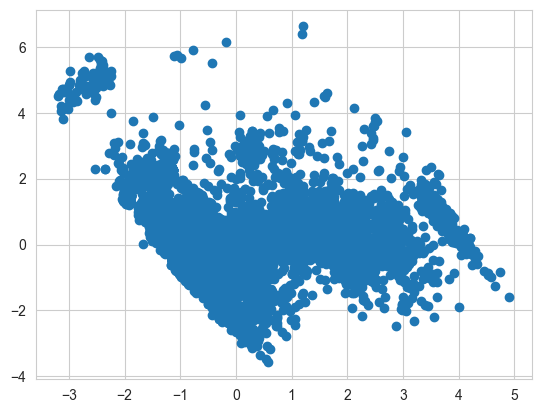

In [68]:
plt.scatter(df_fl_pca[:,0], df_fl_pca[:,1])

### Selecting the k and epsilon plotting the k-distance graph

We do as before for Florida state

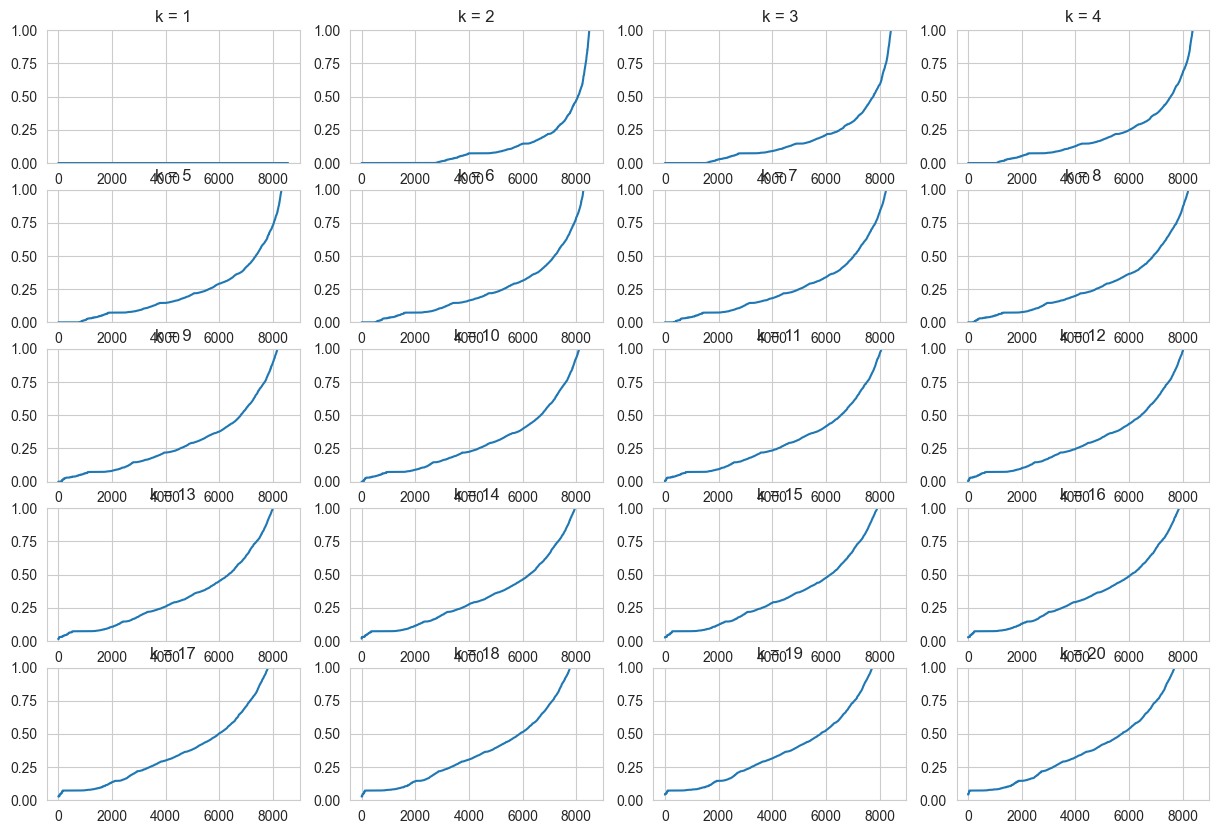

In [69]:
max_k = 20
nbrs = NearestNeighbors(n_neighbors=max_k).fit(df_fl_scaled)
fig , ax = plt.subplots(5, 4, figsize=(15,10))
for k in range(max_k):
    distances, indices = nbrs.kneighbors(df_fl_scaled)
    distances = np.sort(distances, axis=0)
    distances = distances[:,k]
    ax[k//4, k%4].plot(distances)
    ax[k//4, k%4].set_title('k = {}'.format(k+1))
    ax[k//4, k%4].set_ylim([0, 1])

We pick the number of points min_samples=10 and radius eps=0.6 

In [70]:
dbscan= DBSCAN(eps=0.6, min_samples=10).fit(df_fl_scaled)
df_fl['cluster_dbscan'] = dbscan.labels_
df_fl['cluster_dbscan'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\2176782065.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fl['cluster_dbscan'] = dbscan.labels_


 0     5298
 1     1065
-1      958
 6      386
 3      210
 2      190
 5      177
 13      38
 4       36
 8       28
 20      19
 12      17
 10      16
 7       15
 18      15
 17      15
 9       14
 11      14
 14      12
 21      11
 19      11
 16       9
 15       7
Name: cluster_dbscan, dtype: int64

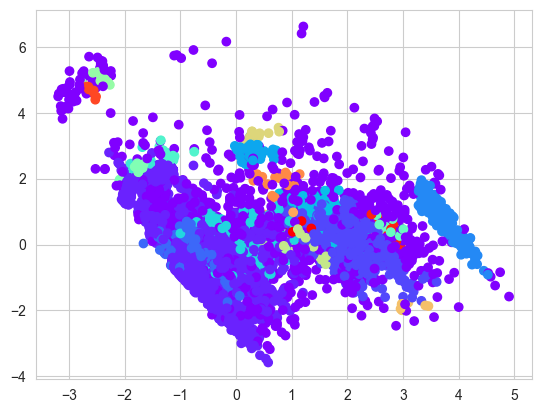

In [71]:
plt.scatter(df_fl_pca[:,0], df_fl_pca[:,1], c=df_fl['cluster_dbscan'], cmap='rainbow')

In [72]:
#plot 3d
pca= PCA(n_components=3)
df_fl_pca = pca.fit_transform(df_fl_scaled)

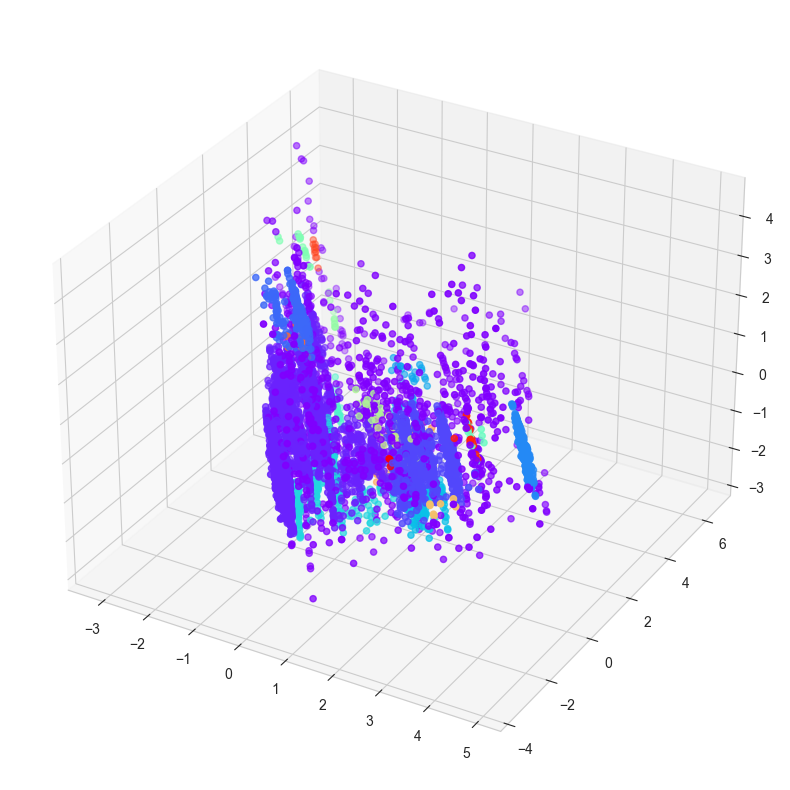

In [73]:

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_fl_pca[:,0], df_fl_pca[:,1], df_fl_pca[:,2], c=df_fl['cluster_dbscan'], cmap='rainbow')

## Hierarchical clustering
We try some linkage methods for Hierarchical clustering (complete, ward, single) on the state of California and then show the clusters on the previous 2-Dimensional PCA plot

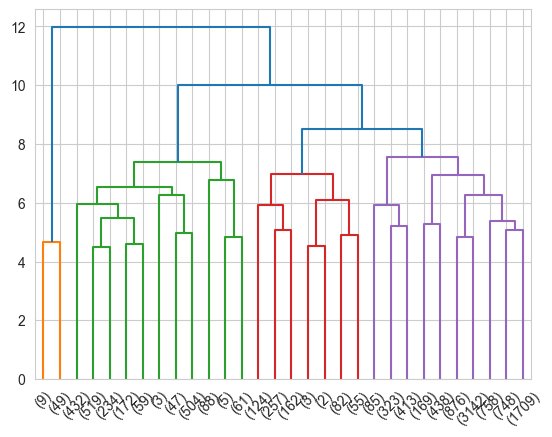

In [74]:
from scipy.stats import mode
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram

data_dist = pdist( df_ca_scaled , metric='euclidean')
data_link = linkage(data_dist, method='complete', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

In [75]:
from sklearn.cluster import AgglomerativeClustering
aggcluster = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='complete')
aggcluster.fit_predict(df_ca_scaled)
df_ca['cluster_agg_comp'] = aggcluster.labels_
df_ca['cluster_agg_comp'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\4111543711.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_agg_comp'] = aggcluster.labels_


0    8661
2    2124
1     685
3      58
Name: cluster_agg_comp, dtype: int64

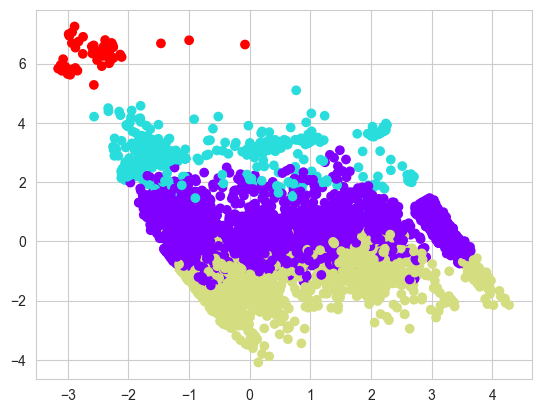

In [76]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca['cluster_agg_comp'], cmap='rainbow')

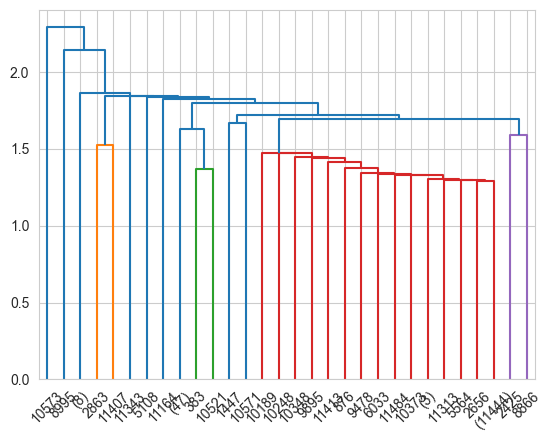

In [77]:
data_dist = pdist( df_ca_scaled , metric='euclidean')
data_link = linkage(data_dist, method='single', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

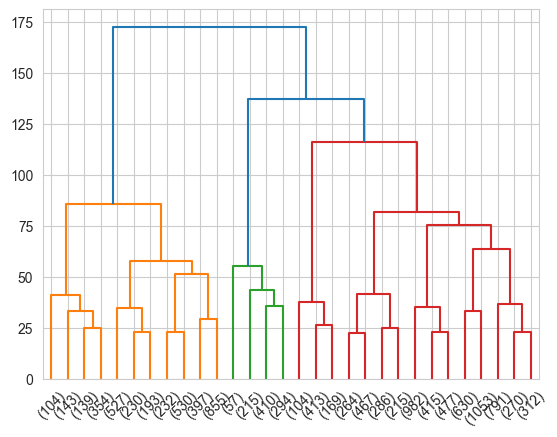

In [78]:
data_dist = pdist( df_ca_scaled , metric='euclidean')
data_link = linkage(data_dist, method='ward', metric='euclidean')
res = dendrogram(data_link, truncate_mode='lastp')

from the dendrogram, we can see that the red cluster can be splitted in two clusters, so we can try to use 4 clusters.

In [79]:
aggcluster_ward = AgglomerativeClustering(n_clusters=4, affinity='euclidean', linkage='ward')
aggcluster_ward.fit_predict(df_ca_scaled)
df_ca['cluster_agg_ward'] = aggcluster_ward.labels_
df_ca['cluster_agg_ward'].value_counts()

C:\Users\HUAWEI\AppData\Local\Temp\ipykernel_32408\3969782099.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ca['cluster_agg_ward'] = aggcluster_ward.labels_


1    6162
0    3704
2     976
3     686
Name: cluster_agg_ward, dtype: int64

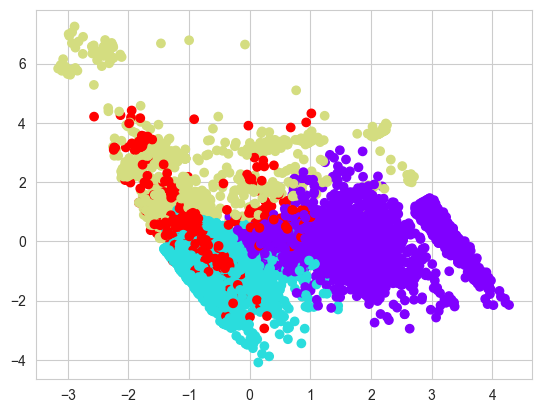

In [80]:
plt.scatter(df_ca_pca[:,0], df_ca_pca[:,1], c=df_ca['cluster_agg_ward'], cmap='rainbow')

In [81]:
#todo ran kmeans on the clusters obtained with hierarchical clustering

## Cluster validation
TODO